In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import cv2 as cv
import open3d
import numpy as np

from utils.io_utils import (
    get_matching_pairs, get_images, get_depths, 
    get_calib_params_from_json, get_opencv_dist_coeffs_from_azure_calib_dict)

from utils.calib_utils import (
    detect_keypoints, detect_charuco_keypoints, undistort_intrinsics, 
    to_homogeneous, to_cartesian, undistort_images, pointcloudify_kp,
    plane2plane_transformation, to_normalized_image_coord,
    project2image, compose_fund_mat, optimize_pose_lm, pointcloudify_depths, 
    optimize_translation_lm, average_transforms)

from utils.vis_utils import (
    plot_figures, plot_projected_keypoints, plot_projected_pcd, to_open3d, 
    plot_epipolar_lines_chess, draw_chessboard_corners, normalize_image)

np.set_printoptions(suppress=True)

### Load data

In [6]:
data_root = (
    '/home/ma/patata/volume1/datasets/navigine/'
    'navigine-extrinsics-calib-seq/extracted-data/2022-11-28-16-03-54/Azure3m')

# Data paths
color_images_path = data_root + "/color"
ir_images_path = data_root + "/ir"
depth_images_path = data_root + "/depth"

color_ext = '.jpg'
ir_ext = '.png'
depth_ext = '.png'

# Crop timestamps for each sequence to exclude moving objects
'''Marsel: I didn't exclude images with movements since the solution 
chooses the optimal pair of images from the entire set of images 
where a marker is detected.
'''
begin = 0
end = -1
period = 1

# List for final transformations for each sequence
T_out = []

In [7]:
# Chessboard params
pattern_size = (8, 6)
edge_length = 0.4947/9 # length in meters

In [8]:
# Deterime matching pairs between color and depth either by matching or providing the list of timestamps manually
color_timestamps, ir_timestamps = get_matching_pairs(color_images_path, ir_images_path)

# Select timestamp pairs
color_timestamps = color_timestamps[begin:end:period]
ir_timestamps = ir_timestamps[begin:end:period]

In [9]:
color_images = get_images(color_images_path, file_name_list=[fn + color_ext for fn in color_timestamps])
ir_images = get_images(ir_images_path, file_name_list=[fn + ir_ext for fn in ir_timestamps])
depth_images = get_depths(depth_images_path, file_name_list=[fn + depth_ext for fn in ir_timestamps])

In [10]:
# Load intrinsics cailbration results which should include 
# intrinsics, distortion coefficients and undistorted intrinsics
def get_calibration_params(path, camera, images):
    params = get_calib_params_from_json(path, camera)
    intrinsics = params['K']
    dist_coeffs = get_opencv_dist_coeffs_from_azure_calib_dict(params)
    undist_intrinsics = undistort_intrinsics(params['size'], intrinsics, dist_coeffs)
    
    return intrinsics, dist_coeffs, undist_intrinsics

color_intrinsics, color_dist_coeffs, color_undist_intrinsics = get_calibration_params(
    f'{data_root}/calib_params.json', 'color', color_images)

ir_intrinsics, ir_dist_coeffs, ir_undist_intrinsics = get_calibration_params(
    f'{data_root}/calib_params.json', 'ir', ir_images)

In [11]:
# Undistort all data before the work
color_images = undistort_images(
    color_images, color_intrinsics, color_dist_coeffs, color_undist_intrinsics, cv.INTER_LINEAR)

ir_images = undistort_images(
    ir_images, ir_intrinsics, ir_dist_coeffs, ir_undist_intrinsics, cv.INTER_LINEAR)

depth_images = undistort_images(
    depth_images, ir_intrinsics, ir_dist_coeffs, ir_undist_intrinsics, cv.INTER_NEAREST)

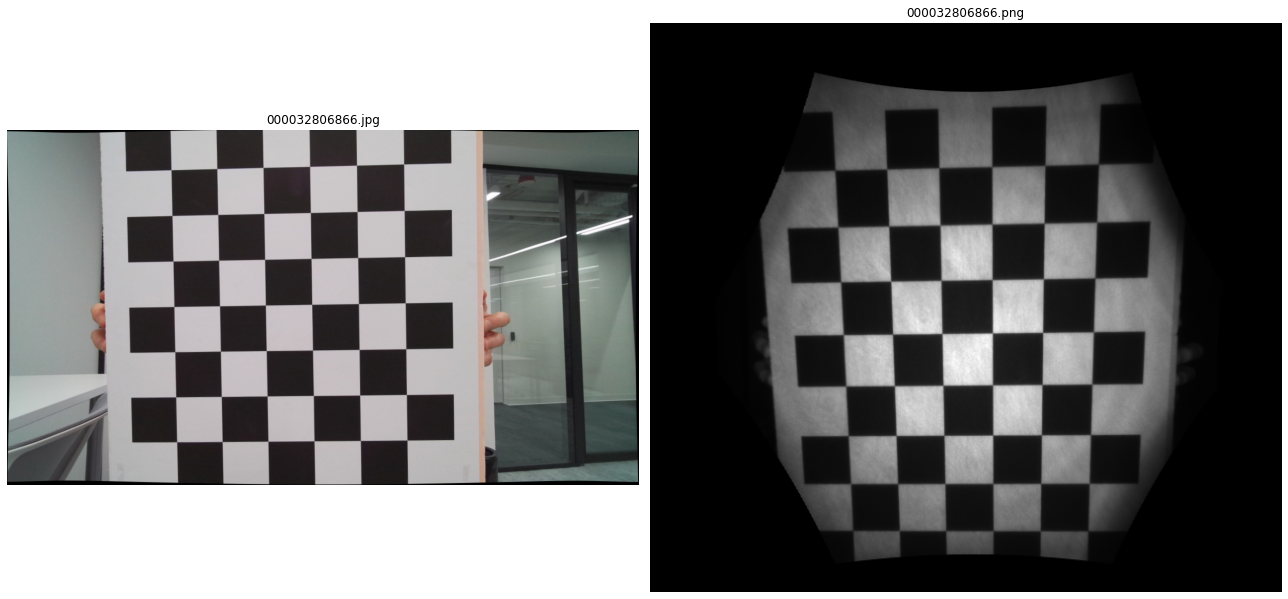

In [12]:
idx = 160

check_color_key, check_ir_key = color_timestamps[idx], ir_timestamps[idx]

plot_figures({check_color_key + color_ext: color_images[check_color_key + color_ext], 
              check_ir_key + ir_ext: ir_images[check_ir_key + ir_ext]}, 1, 2)

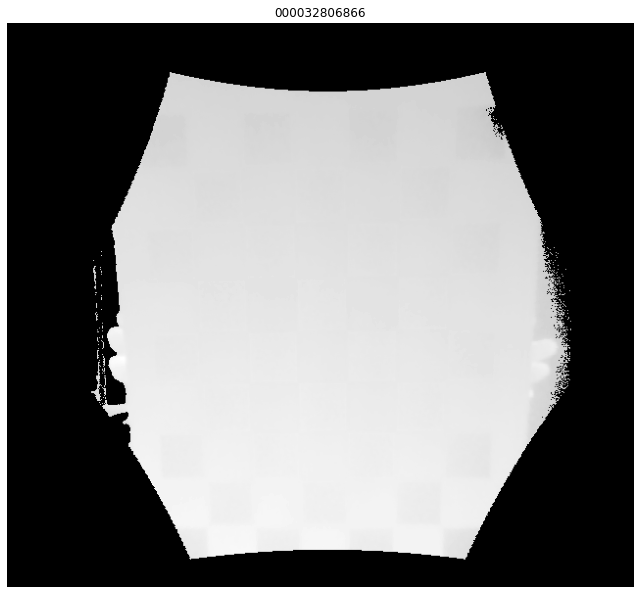

In [13]:
check_depth = depth_images[check_ir_key + depth_ext]

plot_figures({check_ir_key: check_depth}, size=(9, 9))

### Detect keypoints

In [14]:
# Detect keypoint
color_detections = detect_keypoints(color_images, pattern_size, edge_length)
ir_detections = detect_keypoints(ir_images, pattern_size, edge_length, invert=False)

In [15]:
# Leave only those pairs that have detections on both images
board_is_detected_on_color = np.array([t + color_ext in color_detections for t in color_timestamps])
board_is_detected_on_ir = np.array([t + ir_ext in ir_detections for t in ir_timestamps])
board_is_detected_on_both = board_is_detected_on_color & board_is_detected_on_ir

detected_color_timestamps, detected_ir_timestamps = color_timestamps[board_is_detected_on_both], ir_timestamps[board_is_detected_on_both]

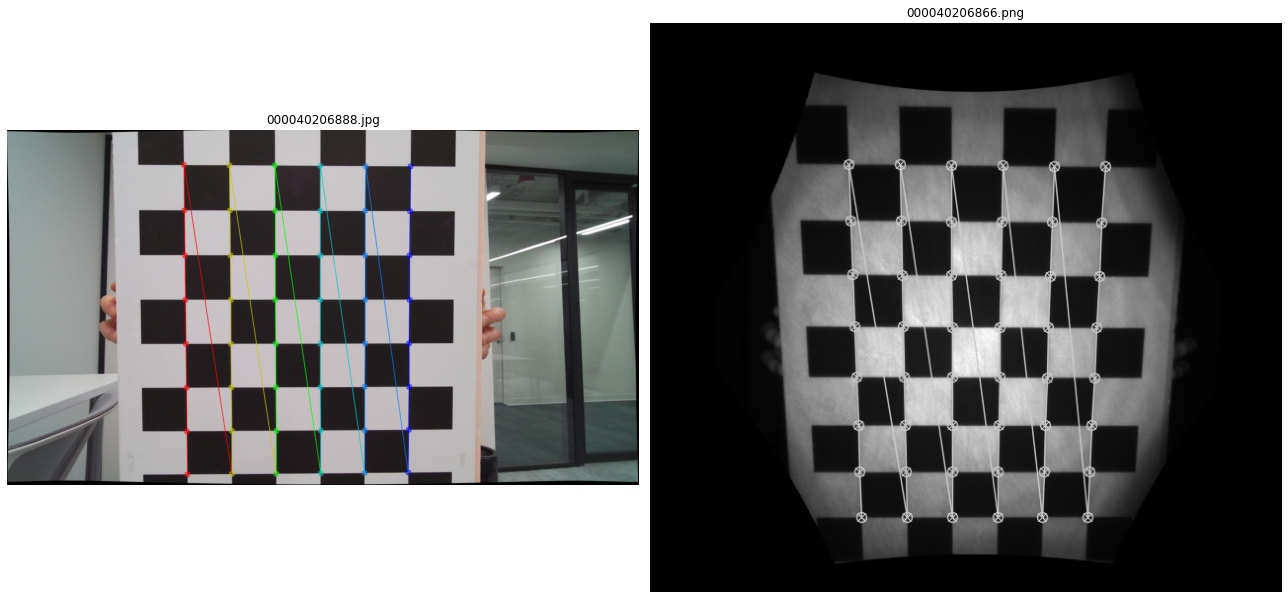

In [16]:
# Detections on ir camera may be innacurate. When selecting final pair make sure their detections are accurate

idx = 7

check_color_key, check_ir_key = detected_color_timestamps[idx] + color_ext, detected_ir_timestamps[idx] + ir_ext

plot_figures({check_color_key: draw_chessboard_corners(color_images[check_color_key], 
                                                     color_detections[check_color_key][1], 
                                                     pattern_size),
              check_ir_key: draw_chessboard_corners(ir_images[check_ir_key], 
                                                       ir_detections[check_ir_key][1], 
                                                       pattern_size)}, 1, 2)

### color-to-chessboard transformation

In [17]:
# Solve PnP for find transformation between color keypoints and points on the board

color_chess = {}

for ts in detected_color_timestamps:
    scene_points, kp = color_detections[ts + color_ext]
    success, r, t = cv.solvePnP(scene_points, kp, color_undist_intrinsics, None, flags=cv.SOLVEPNP_IPPE)
    
    if success:
        dS = np.zeros((4, 4))
        dS[:3, :3] = cv.Rodrigues(r)[0]
        dS[:3, 3] = np.reshape(t, -1)
        dS[3, 3] = 1
        
        color_local_scene_points = to_cartesian((dS @ to_homogeneous(scene_points).transpose()).transpose())
        
        color_chess[ts] = color_local_scene_points


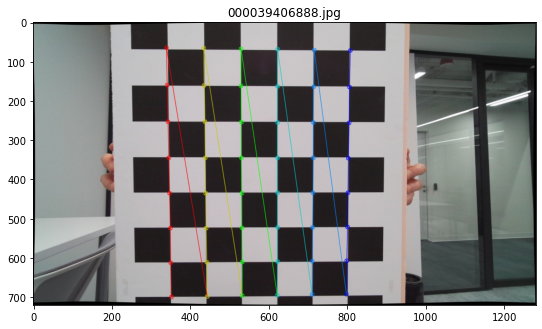

In [18]:
# Visualize transformed scene points with the estimated by PnP transformation to make sure the solution make sense
idx = 4

check_key = detected_color_timestamps[idx] + color_ext

plot_projected_keypoints(color_images[check_key], color_chess[check_key.split('.')[0]], color_undist_intrinsics, check_key, pattern_size)

### ir-to-chessboard transformation

In [19]:
# Take keypoints from ir and use depth to create a point cloud out of them

ir_chess = {}

for t in detected_ir_timestamps:
    kp = np.squeeze(ir_detections[t + ir_ext][1], 1)
    depth = depth_images[t + depth_ext]
    
    norm_kp = to_normalized_image_coord(kp, ir_undist_intrinsics)
    
    depth_local_kp = pointcloudify_kp(kp, norm_kp, depth)
    
    ir_chess[t] = depth_local_kp

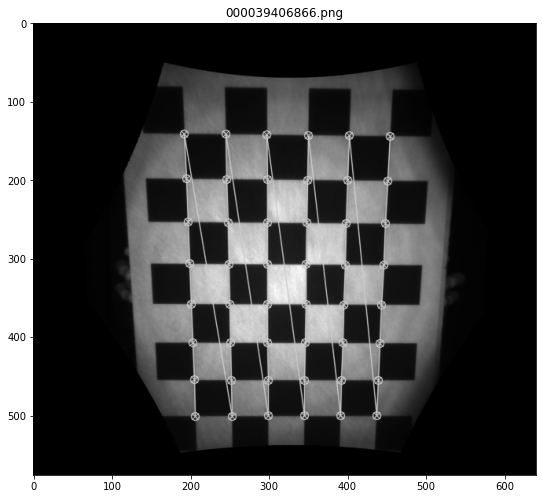

In [20]:
# Again perform the check to make sure that obtained points are reasonable
idx = 4

check_key = detected_ir_timestamps[idx] + depth_ext

plot_projected_keypoints(ir_images[check_key], 
                         ir_chess[check_key.split('.')[0]], 
                         ir_undist_intrinsics, 
                         check_key, 
                         pattern_size)

In [21]:
# Visualize two chessboards next to each other and get the avg. error between corresponding points

idx = 4

check_ir_chess, check_color_chess = ir_chess[detected_ir_timestamps[idx]], color_chess[detected_color_timestamps[idx]]

open3d.visualization.draw_geometries([to_open3d(check_ir_chess), to_open3d(check_color_chess)])

In [22]:
np.linalg.norm(check_color_chess - check_ir_chess, axis=-1).mean()

0.051952426845727095

### ir-color-extrinsics guess

In [23]:
# Estimate the point-to-point transformation between two pointclouds

extrinsics = {}

for color_t, ir_t in zip(detected_color_timestamps, detected_ir_timestamps):
    color_chessi = color_chess[color_t]
    ir_chessi = ir_chess[ir_t]
    
    extrinsics[color_t + ' ' + ir_t] = plane2plane_transformation(ir_chessi, color_chessi)


In [24]:
# Pick only one solution (T_init) that corresponds to a pair with the best inital estimate. 
# IMPORTANT: Make sure the transformation is geometrically feasible

t_norm_p2p = []
T_p2p = []

for i, (color_t, ir_t) in enumerate(zip(detected_color_timestamps, detected_ir_timestamps)):
    ir_chessi, color_chessi = ir_chess[ir_t], color_chess[color_t]
    Ti = extrinsics[color_t + ' ' + ir_t]
    
    t_ir_chessi = to_cartesian((Ti @ to_homogeneous(ir_chessi).transpose()).transpose())
    
    t_normi = np.linalg.norm(t_ir_chessi - color_chessi, axis=-1).mean()
    
    t_norm_p2p.append(t_normi)
    T_p2p.append(Ti)

t_norm_p2p = np.array(t_norm_p2p)
T_p2p = np.array(T_p2p)

In [25]:
t_norm_idx = np.argsort(t_norm_p2p)

T_init = T_p2p[t_norm_idx[20]]

print(T_init)

[[ 0.99710916 -0.00270841  0.04908822 -0.05385859]
 [-0.00143172  0.9977809  -0.00013731  0.04273004]
 [ 0.04917114 -0.0002015   1.00250709 -0.00578988]
 [ 0.          0.          0.          1.        ]]


In [26]:
# Check the selected transformation
idx = 13

check_ir_key, check_color_key = detected_ir_timestamps[idx], detected_color_timestamps[idx]

check_ir_chess, check_color_chess = ir_chess[check_ir_key], color_chess[check_color_key]

check_T = T_init

In [27]:
# 1) avg. error between points
check_t_ir_chess = to_cartesian((check_T @ to_homogeneous(check_ir_chess).transpose()).transpose())

np.linalg.norm(check_t_ir_chess - check_color_chess, axis=-1).mean()

0.29438199144309385

In [28]:
# 2) by examining the solution visually
open3d.visualization.draw_geometries([to_open3d(check_t_ir_chess), to_open3d(check_color_chess)])

In [29]:
# The initial solution as can be seen from epipolar lines is highly inaccurate thus we need to further 
# minimize avg. epipolar distance

T_opt = []

t_norm = []

for i, (color_t, ir_t) in enumerate(zip(detected_color_timestamps, detected_ir_timestamps)):    
    color_kp, ir_kp = np.squeeze(color_detections[color_t + color_ext][1]), np.squeeze(ir_detections[ir_t + depth_ext][1])
    local_kp1i = ir_chess[ir_t]
    
    print("Index:", i)
    
    # Do separate optimization for the initial guess to find pairs where the convergence is possible with relatively low error
    
    print("F optimization")
    
    T_opti = optimize_pose_lm(T_init, ir_kp, color_kp, ir_undist_intrinsics, color_undist_intrinsics)    
    
    if T_opti is not None:
        # Do optimization to find translation magnitude
        
        print("t optimization")
        
        T_opti, t_normi = optimize_translation_lm(T_opti, local_kp1i, color_kp, color_undist_intrinsics)
        
        T_opt.append(T_opti)
        
        t_norm.append(t_normi)
    
    print()

t_norm = np.array(t_norm)
T_opt = np.array(T_opt)
best_t_norm_idx = np.argsort(t_norm)

Index: 0
F optimization
Avg. epipolar distance: 0.19843030213281074
Number of iters: 19
t optimization
Avg. l2-norm: 0.5149035695504002
Number of iters: 29
Translation scale: 0.06338945328609695

Index: 1
F optimization
Avg. epipolar distance: 0.0928871629671359
Number of iters: 9
t optimization
Avg. l2-norm: 0.2772953084764871
Number of iters: 45
Translation scale: 0.03306301917506606

Index: 2
F optimization
Avg. epipolar distance: 0.09244813304127447
Number of iters: 9
t optimization
Avg. l2-norm: 0.31583390021199037
Number of iters: 25
Translation scale: 0.03300677664281874

Index: 3
F optimization
Avg. epipolar distance: 0.10679085662171332
Number of iters: 9
t optimization
Avg. l2-norm: 0.3066523284420534
Number of iters: 33
Translation scale: 0.03319812056777063

Index: 4
F optimization
Avg. epipolar distance: 0.10548441210055126
Number of iters: 9
t optimization
Avg. l2-norm: 0.3922395609006187
Number of iters: 25
Translation scale: 0.03303297309119056

Index: 5
F optimization


Avg. epipolar distance: 0.09681119948198928
Number of iters: 9
t optimization
Avg. l2-norm: 0.22809512978788857
Number of iters: 39
Translation scale: 0.03311914005293239

Index: 54
F optimization
Avg. epipolar distance: 0.09794088629851072
Number of iters: 9
t optimization
Avg. l2-norm: 0.23116422683611826
Number of iters: 33
Translation scale: 0.03296056612851849

Index: 55
F optimization
Avg. epipolar distance: 0.10569717932056406
Number of iters: 9
t optimization
Avg. l2-norm: 0.238960502447073
Number of iters: 39
Translation scale: 0.0329596968949281

Index: 56
F optimization
Avg. epipolar distance: 0.10100506364629985
Number of iters: 11
t optimization
Avg. l2-norm: 0.24521789146480022
Number of iters: 39
Translation scale: 0.03316861286517904

Index: 57
F optimization
Avg. epipolar distance: 0.09832273720504081
Number of iters: 9
t optimization
Avg. l2-norm: 0.24011232004471186
Number of iters: 37
Translation scale: 0.033170682384375136

Index: 58
F optimization
Avg. epipolar di

Avg. epipolar distance: 0.10958846564720155
Number of iters: 8
t optimization
Avg. l2-norm: 0.3595379451972893
Number of iters: 17
Translation scale: 0.033861745946997715

Index: 103
F optimization
Avg. epipolar distance: 0.10695167767056028
Number of iters: 8
t optimization
Avg. l2-norm: 0.2635807827081202
Number of iters: 35
Translation scale: 0.033184720079276656

Index: 104
F optimization
Avg. epipolar distance: 0.12420889189000335
Number of iters: 8
t optimization
Avg. l2-norm: 0.26855895205956304
Number of iters: 35
Translation scale: 0.03349099775302747

Index: 105
F optimization
Avg. epipolar distance: 0.12279611324122541
Number of iters: 8
t optimization
Avg. l2-norm: 0.25472250269760344
Number of iters: 41
Translation scale: 0.03319764195638874

Index: 106
F optimization
Avg. epipolar distance: 0.11740687994746708
Number of iters: 7
t optimization
Avg. l2-norm: 0.26707127519141455
Number of iters: 29
Translation scale: 0.033584401023180145

Index: 107
F optimization
Avg. epip

Avg. l2-norm: 0.3242324985948328
Number of iters: 19
Translation scale: 0.033258899359500584

Index: 160
F optimization
Avg. epipolar distance: 0.12486604295809389
Number of iters: 8
t optimization
Avg. l2-norm: 0.46299270719022667
Number of iters: 19
Translation scale: 0.03270439671718485

Index: 161
F optimization
Avg. epipolar distance: 0.14166787349503393
Number of iters: 8
t optimization
Avg. l2-norm: 0.3174627325633284
Number of iters: 49
Translation scale: 0.033395442876498274

Index: 162
F optimization
Avg. epipolar distance: 0.12556431241109234
Number of iters: 8
t optimization
Avg. l2-norm: 0.34803119924227727
Number of iters: 25
Translation scale: 0.03271405609334064

Index: 163
F optimization
Avg. epipolar distance: 0.10248437779913822
Number of iters: 7
t optimization
Avg. l2-norm: 0.3243254655818191
Number of iters: 19
Translation scale: 0.0331336694130592

Index: 164
F optimization
Avg. epipolar distance: 0.11067887993430474
Number of iters: 8
t optimization
Avg. l2-norm

Avg. epipolar distance: 0.10348066865741234
Number of iters: 8
t optimization
Avg. l2-norm: 0.29701366815052926
Number of iters: 23
Translation scale: 0.03195306490910978

Index: 217
F optimization
Avg. epipolar distance: 0.10257280156693288
Number of iters: 8
t optimization
Avg. l2-norm: 0.25305858257134967
Number of iters: 39
Translation scale: 0.03223766184676766

Index: 218
F optimization
Avg. epipolar distance: 0.1044000332681636
Number of iters: 8
t optimization
Avg. l2-norm: 0.29733628393920514
Number of iters: 19
Translation scale: 0.03160347842833281

Index: 219
F optimization
Avg. epipolar distance: 0.11535455888554026
Number of iters: 8
t optimization
Avg. l2-norm: 0.3007098303374687
Number of iters: 35
Translation scale: 0.031493207455822576

Index: 220
F optimization
Avg. epipolar distance: 0.10645587191147737
Number of iters: 8
t optimization
Avg. l2-norm: 0.3292199240568192
Number of iters: 23
Translation scale: 0.0314220249671347

Index: 221
F optimization
Avg. epipolar

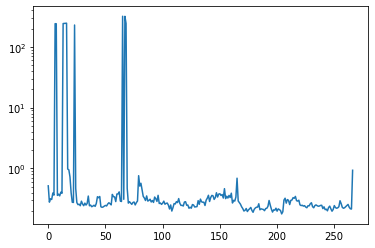

In [30]:
import matplotlib.pyplot as plt
plt.semilogy(t_norm)

In [31]:
# Select T to examine
# np.arange(len(best_t_norm_idx))
select_idx = 0
selected_idx = best_t_norm_idx[select_idx]

print("Selected best idx:", selected_idx)
print("Selected avg. norm:", t_norm[selected_idx])

sel_T_opt = T_opt[selected_idx]

Selected best idx: 204
Selected avg. norm: 0.17754194528523648


In [32]:
sel_T_opt

array([[ 0.99998755,  0.00498989,  0.00006463, -0.03386705],
       [-0.00497049,  0.99477988,  0.10192293, -0.0018248 ],
       [ 0.00044429, -0.10192198,  0.9947923 , -0.00296518],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Visualize transformed keypoints, depth

In [33]:
# Either select one transformation or average over several of them

# T_final = average_transforms(sel_T_opt)
T_final = sel_T_opt

In [34]:
T_final

array([[ 0.99998755,  0.00498989,  0.00006463, -0.03386705],
       [-0.00497049,  0.99477988,  0.10192293, -0.0018248 ],
       [ 0.00044429, -0.10192198,  0.9947923 , -0.00296518],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [35]:
# Transform all depth measurements to a point cloud
pcd_depths = pointcloudify_depths(depth_images, ir_undist_intrinsics)

Re-proj. error:  0.3839308820846563


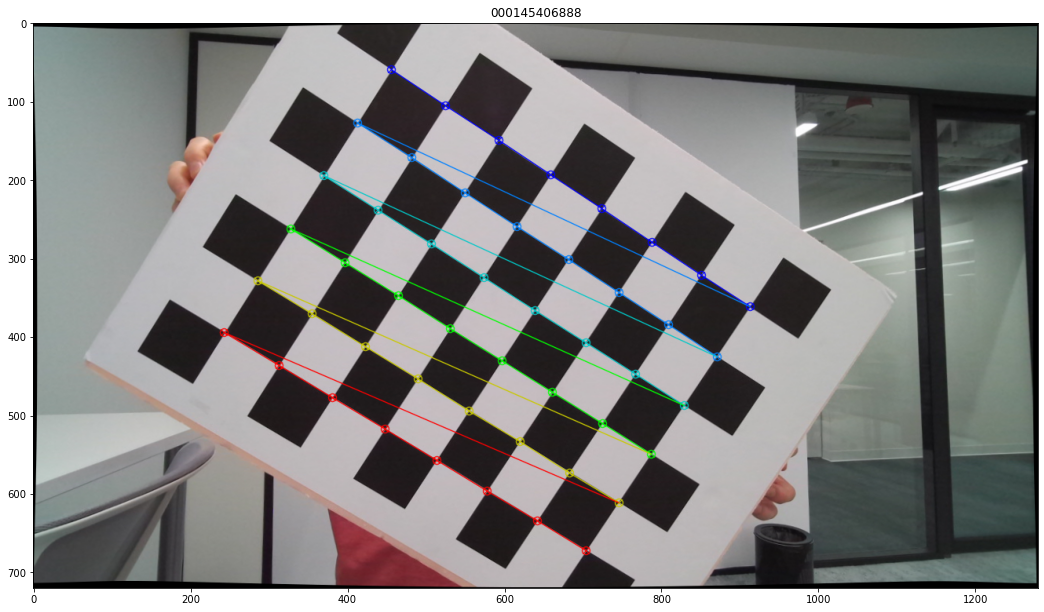

In [36]:
# Keypoints should be well aligned with their respective locations on multiple images

idx = -20

check_ir_key, check_color_key = detected_ir_timestamps[idx], detected_color_timestamps[idx]

check_ir_chess = to_cartesian((T_final @ to_homogeneous(ir_chess[check_ir_key]).transpose()).transpose())
check_color_kp = np.squeeze(color_detections[check_color_key + color_ext][1], 1)

check_re_proj_error = np.linalg.norm(project2image(check_ir_chess, color_undist_intrinsics) - check_color_kp, axis=-1).mean()

print("Re-proj. error: ", check_re_proj_error)

plot_projected_keypoints(color_images[check_color_key + color_ext], check_ir_chess, 
                         color_undist_intrinsics, check_color_key, pattern_size, fig_size=(18, 18))


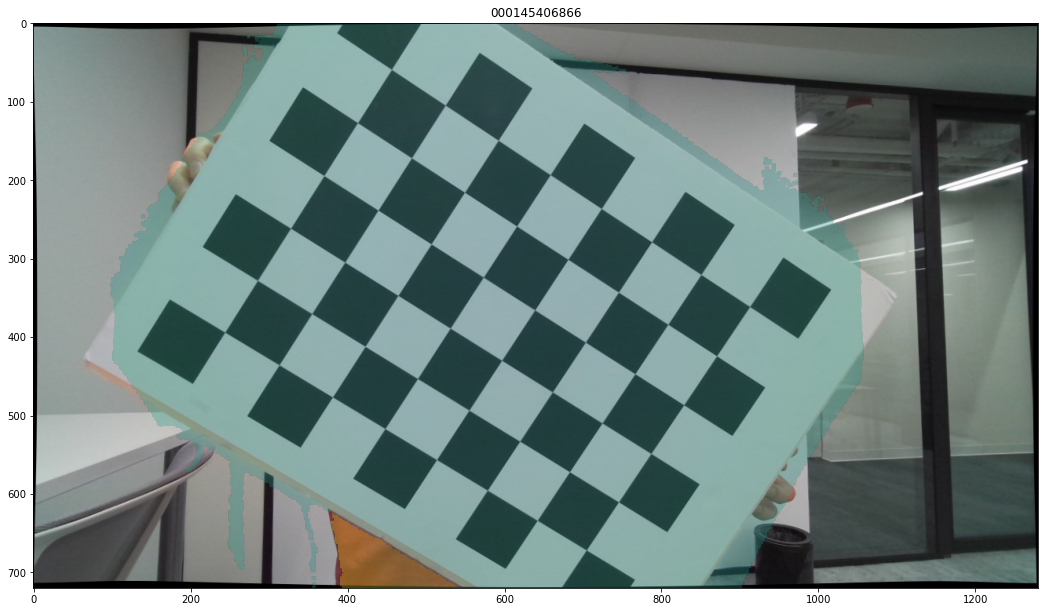

In [37]:
# Transform pointcloudified depth from depth (ir) to color system of coordinates and visualize it as a final check

check_depth_pcd = pcd_depths[check_ir_key + depth_ext]
check_depth_pcd = to_cartesian((T_final @ to_homogeneous(check_depth_pcd).transpose()).transpose())

plot_projected_pcd(color_images[check_color_key + color_ext], check_depth_pcd, color_undist_intrinsics, check_ir_key)

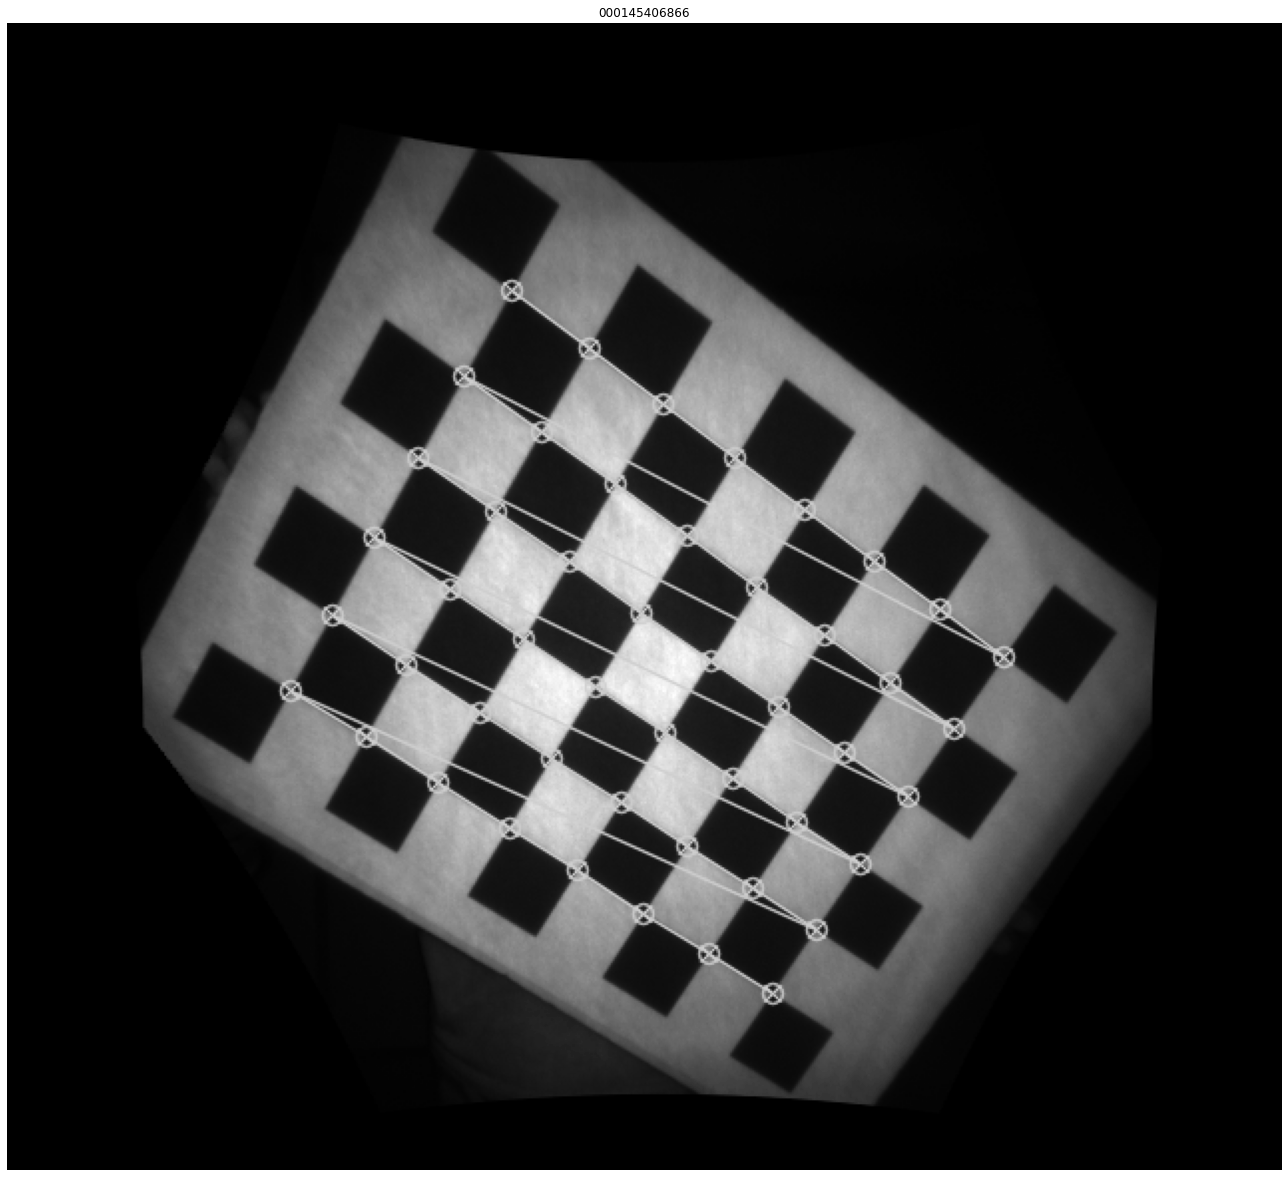

In [38]:
plot_figures({check_ir_key: draw_chessboard_corners(ir_images[check_ir_key + ir_ext], 
                                                       ir_detections[check_ir_key + ir_ext][1], 
                                                       pattern_size)})

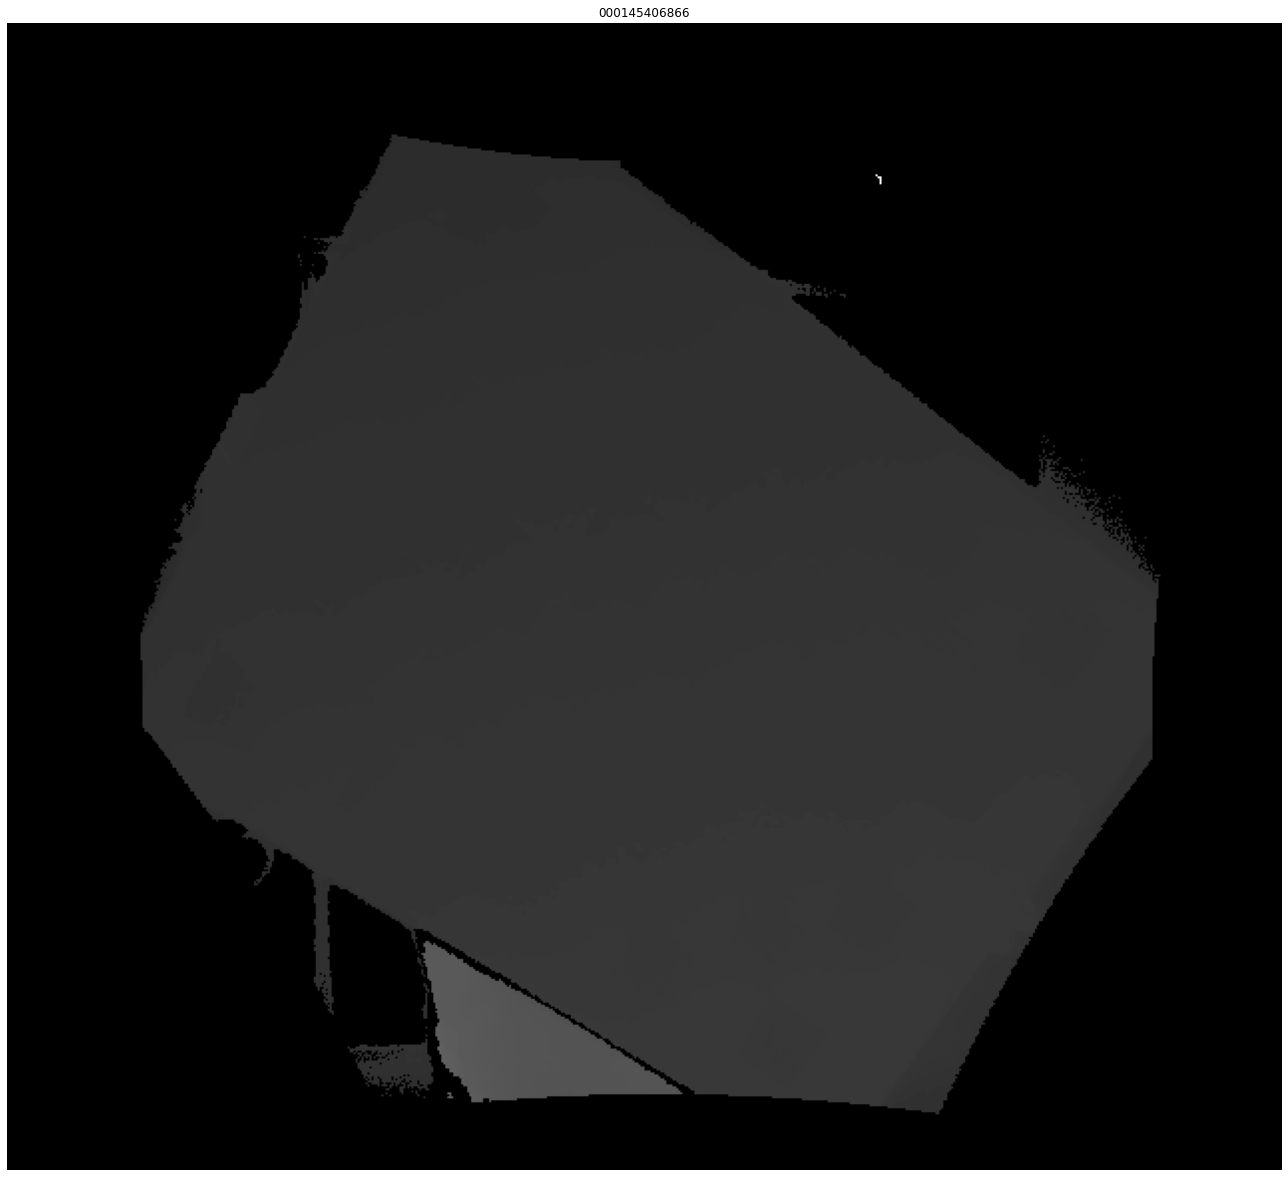

In [39]:
plot_figures({check_ir_key: depth_images[check_ir_key + depth_ext]})

In [40]:
# Add transformation to the list
T_out.append(T_final)

In [41]:
# Optional. Save if needed
# np.save('calib_output/depth_to_color_extrinsics1', T_final)

In [42]:
# Merge all the transformations together
T_avg = average_transforms(T_out)

In [43]:
T_avg

array([[ 0.99998755,  0.00498989,  0.00006463, -0.03386705],
       [-0.00497049,  0.99477988,  0.10192293, -0.0018248 ],
       [ 0.00044429, -0.10192198,  0.9947923 , -0.00296518],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [44]:
np.save('calib_output/depth_to_color_extrinsics', T_avg)